# Modelo SchNet


*   n_atom_basis=30
*   n_filters=30
*   n_gaussians=20
*   n_interactions=5
*   cutoff=4.
*   cutoff_network=CosineCutoff
*   Adam 1e-2
*   ReduceLROnPlateauHook hasta 1e-6



In [1]:
!pip install schnetpack
!pip install ase
!pip install nglview
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd
from  schnetpack import AtomsData
import schnetpack as spk
import schnetpack.train as trn
from ase.io import read
from ase.visualize.plot import plot_atoms
from ase.lattice.cubic import FaceCenteredCubic
from torch.optim import Adam
import torch
import math
from ase import Atoms
qmH2O = '/content/drive/My Drive/Colab Notebooks/SchNet Files/qmH2O_1/'
SchNet_Files = '/content/drive/My Drive/Colab Notebooks/SchNet Files/'
Files = '/content/drive/My Drive/Colab Notebooks/'
device = "cuda" 

     |████████████████████████████████| 266kB 12.6MB/s 
     |████████████████████████████████| 317kB 16.9MB/s 
     |████████████████████████████████| 2.2MB 23.3MB/s 
     |████████████████████████████████| 5.2MB 13.7MB/s 
  Created wheel for nglview: filename=nglview-2.7.7-cp36-none-any.whl size=6983522 sha256=c6b0997bb67ca8a03e4ffe29e10baaba7ab4b92687ba3eac8253fb8d8a9908df
  Stored in directory: /root/.cache/pip/wheels/24/14/56/fc0406301850d9d017a748b568b2e97566148deda046ac56dc
Successfully built nglview


# DB ASE 
Una DB ASE es una SQL Lite para átomos y moléculas. Si existe el archivo de DB se cargan sus datos, si no existe se crea el fichero DB vacío 

In [3]:
new_dataset = AtomsData(SchNet_Files + 'new_dataset_H2O.db')

# Carga de datos en DB a partir de fichero en formato xyz
# Comentado! 
Esto se hace una vez en local y sirve para todos los entrenamnientos

1.   Se importa el archivo xyz con la información de las 
moléculas y sus propiedades. En nuestro caso:
*   Posición de los átomos
*   Energía



In [ ]:
#atoms = read('/content/drive/My Drive/Colab Notebooks/output_h2o_HF_ccpvdz_to_SchNet.xyz', index=':17636')
#print(len(atoms))

17636


2.   Se pueden visualizar las moléculas



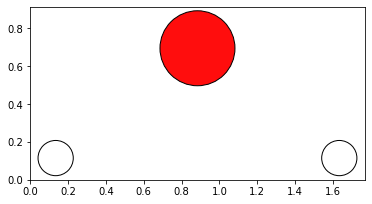

In [ ]:
#fig, ax = plt.subplots()
#plot_atoms(atoms[12852], ax, radii=0.3, rotation=('0x,0y,-90z'))

3.   Se crea una lista, solo con las propiedades que no sean posiciones espaciales o vectores de fuerza. En nuestro caso la energía.

In [ ]:
#print('Energy:', atoms[12852].info)

# parse properties as list of dictionaries
#property_list = []
#for at in atoms:
#    energy = np.array([float(list(at.info.keys())[0])], dtype=np.float32)
#    property_list.append(
#        {'energy': energy}
#    )
#print(property_list[12852])
#len(property_list)

Energy: {'-76.027388': True}
{'energy': array([-76.02739], dtype=float32)}


17636

4.   Se carga la información en la DB de forma persistente


In [ ]:
#new_dataset.add_systems(atoms, property_list)

# Creación del conjunto de entrenamiento y validación
Test se deja a cero porque disponemos de un dataset propio.

La partición aleatoria queda reflejada en el archivo split.npz

Si ya existe split.npz mantiene la partición.

Se valida con el 10% (1736) del total del os datos (17363)

In [12]:
train, val, test = spk.train_test_split(
        data=new_dataset,
        num_train=15872,
        num_val=1764,
        split_file= qmH2O +'split.npz',
    )

Comprobamos que hay datos

In [13]:
train.get_properties(15871)
val.get_properties(1763)

/usr/local/lib/python3.6/dist-packages/schnetpack/data/atoms.py:327: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  properties[pname] = torch.FloatTensor(prop)
/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


(Atoms(symbols='OH2', pbc=False),
 {'_atomic_numbers': tensor([8, 1, 1]), '_cell': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]), '_cell_offset': tensor([[[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]]]), '_neighbors': tensor([[1, 2],
          [0, 2],
          [0, 1]]), '_positions': tensor([[-0.0594, -0.0017,  0.0000],
          [ 0.4841,  0.6816,  0.0000],
          [ 0.4594, -0.6540,  0.0000]]), 'energy': tensor([-76.0015])})

# Creación de Data Loaders

In [ ]:
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=20)

# Cálculo de las estadísticas de las propiedades

In [ ]:
atomrefs = new_dataset.get_atomref('energy')
means, stddevs = train_loader.get_statistics(
    property_names ='energy', single_atom_ref=atomrefs
)
print('Mean atomization energy / atom:', means['energy'])
print('Std. dev. atomization energy / atom:', stddevs['energy'])

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Mean atomization energy / atom: tensor([-75.7429])
Std. dev. atomization energy / atom: tensor([0.4271])


# Definición del modelo


1.   Se define el modelo que representa al sistema
2.   Se define la la salida que proporciona la energía a partir del modelo anterior.
2.   Se unen las dos partes en un mismo modelo



In [ ]:
schnet = spk.representation.SchNet(
    n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=5,
    cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
)

output_E = spk.atomistic.Atomwise(n_in=30, atomref=atomrefs['energy'], property='energy',
                                   mean=means['energy'], stddev=stddevs['energy'])

model = spk.AtomisticModel(representation=schnet, output_modules=output_E)

# Definición del Trainer con:
*   Optimizador
*   Función de pérdida mse
*   Métrica MeanAbsoluteError
*   Reducción progresiva de lr con ReduceLROnPlateauHook
*   Ruta donde se guardará el mejor modelo, logs y checkpoints
*   Conjunto de datos de train y validation



In [ ]:
optimizer = Adam(model.parameters(), lr=1e-2)
loss = trn.build_mse_loss(['energy'])
metrics = [spk.metrics.MeanAbsoluteError('energy')]
hooks = [
    trn.CSVHook(log_path=qmH2O, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=3, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]
trainer = trn.Trainer(
    model_path=qmH2O,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

# Entrenamiento del modelo

In [ ]:
n_epochs = 1000

datetime_comienzo = datetime.now()

trainer.train(device=device, n_epochs=n_epochs)

datetime_fin = datetime.now()
print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Tiempo de entrenamiento:5:00:08.642277


# Carga del mejor modelo

In [4]:
best_model = torch.load(qmH2O + 'best_model')

# Inferencia - Energía frente a una distancia de enlace
Fijando la otra distancia de enlace a 1.808 ua y el ángulo a 104.5 grados

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


    rh1    rh2    ang       pred
0  0.80  1.808  104.5 -74.586418
1  0.81  1.808  104.5 -74.640884
2  0.82  1.808  104.5 -74.693924
3  0.83  1.808  104.5 -74.745575
4  0.84  1.808  104.5 -74.795807


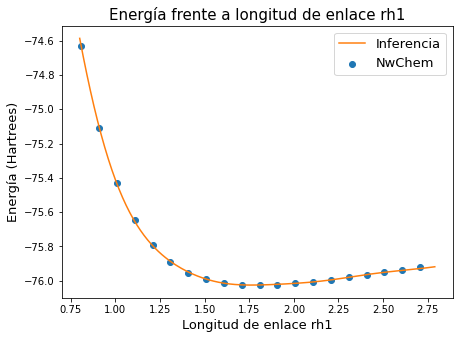

In [8]:
data_df0 = pd.read_csv(Files + "output_plotdata_HF_ccpvdz_continua.csv")
data_long_enlace = data_df0[(np.round(data_df0["ang"],1)==104.5) & (np.round(data_df0["rh2"],3)==1.808)].copy()
r_bhor_angstrom =0.529177

x_arange = pd.DataFrame()
x_arange['rh1'] =np.arange(0.8, 2.8, 0.01)
x_arange['rh2'] =1.808
x_arange['ang']= 104.5
x_arange['pred']= np.nan
converter = spk.data.AtomsConverter(device=device)
for index, row in x_arange.iterrows():
  r1= row["rh1"]*r_bhor_angstrom
  r2= row["rh2"]*r_bhor_angstrom
  seno = math.sin(row["ang"]*math.pi/180/2)
  coseno = math.cos(row["ang"]*math.pi/180/2)
  r1x= r1*coseno
  r2x= r2*coseno
  r1y= r1*seno
  r2y= -r2*seno
  at= Atoms('OH2', positions=[(0, 0, 0), (r1x, r1y, 0),(r2x, r2y, 0)])
  inputs = converter(at)
  pred = best_model(inputs)
  row['pred'] = pred['energy'].detach().cpu().numpy()[0][0]

print(x_arange.head(5))

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_arange['rh1'], x_arange['pred'], 'r-', label='Inferencia',  color='tab:orange')
ax.scatter(data_long_enlace['rh1'], data_long_enlace['energia'], label='NwChem')


ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()

# Inferencia - Energía frente al ángulo

Fijando las dos distancias de enelace a 1.808

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


    ang    rh1    rh2       pred
0  95.0  1.708  1.708 -76.019714
1  95.1  1.708  1.708 -76.019768
2  95.2  1.708  1.708 -76.019836
3  95.3  1.708  1.708 -76.019875
4  95.4  1.708  1.708 -76.019943


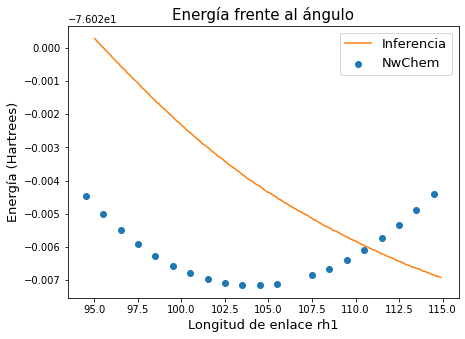

In [10]:
data_ang = data_df0[(np.round(data_df0['rh1'],3)==1.808) & (np.round(data_df0['rh2'],3)==1.808)].copy()
r_bhor_angstrom =0.529177

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.1)
x_arange['rh1'] =1.708
x_arange['rh2'] =1.708
x_arange['pred']= np.nan
converter = spk.data.AtomsConverter(device=device)
for index, row in x_arange.iterrows():
  r1= row["rh1"]*r_bhor_angstrom
  r2= row["rh2"]*r_bhor_angstrom
  seno = math.sin(row["ang"]*math.pi/180/2)
  coseno = math.cos(row["ang"]*math.pi/180/2)
  r1x= r1*coseno
  r2x= r2*coseno
  r1y= r1*seno
  r2y= -r2*seno
  at= Atoms('OH2', positions=[(0, 0, 0), (r1x, r1y, 0),(r2x, r2y, 0)])
  inputs = converter(at)
  pred = best_model(inputs)
  row['pred'] = pred['energy'].detach().cpu().numpy()[0][0]

print(x_arange.head(5))

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_arange['ang'], x_arange['pred'], label='Inferencia',  color='tab:orange')
ax.scatter(data_ang['ang'], data_ang['energia'], label='NwChem')

ax.set_title('Energía frente al ángulo', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()